# 等离子体电子声不稳定性：Two-kappa Electrons Model

In [1]:
import numpy as np
from prettytable import PrettyTable
import os
import matplotlib.pyplot as plt
import scipy.signal
import scipy.optimize as op
import plasmapy.mathematics
from scipy import special as sp
from scipy import integrate
from prettytable import PrettyTable
from scipy import fftpack
from tqdm import tqdm
%config InlineBackend.figure_format = 'svg'

## 模型
### 1D等离子体：双kappa运动电子+静止均匀分布离子
- 初始分布函数
$$ f(x,v,0) = \left( f_s + f_f  \right) (1+d \cos kx) $$
$$ f_s = \frac{n_s}{\sqrt{2\pi T (\kappa_s-3/2)}} \frac{\Gamma(\kappa_s)}{\Gamma(\kappa_s-1/2)} \left( 1+\frac{1}{\kappa_s-3/2} \frac{(v-u_s)^2}{2T} \right)^{-\kappa_s} $$
$$ f_f = \frac{n_f}{\sqrt{2\pi T (\kappa_f-3/2)}} \frac{\Gamma(\kappa_f)}{\Gamma(\kappa_f-1/2)} \left( 1+\frac{1}{\kappa_f-3/2} \frac{(v-u_f)^2}{2T} \right)^{-\kappa_f} $$
$$ f_f(\kappa \rightarrow \infty) = \frac{n_f}{\sqrt{2\pi T}} \exp \left[ -\frac{(v-u_s)^2}{2 T}\right]$$
                          
- 色散关系
$$ 1 + \frac{2 \omega_s^2}{k^2 \theta_s^2} \left[ 1 - \frac{1}{2\kappa_s} +\xi_s Z_{\kappa_s}(\xi_s) \right] + \frac{2 \omega_f^2}{k^2 \theta_f^2} \left[ 1 - \frac{1}{2 \kappa_f} +\xi_f Z_{\kappa_f}(\xi_f) \right] = 0 $$
$$ 1 + \frac{2 \omega_s^2}{k^2 \theta_s^2} \left[ 1 - \frac{1}{2\kappa_s} +\xi_s Z_{\kappa_s}(\xi_s) \right] + \frac{2 \omega_f^2}{k^2 \theta_f^2} \left[ 1 + \xi_f Z(\xi_f) \right] = 0 $$
其中$\xi_\sigma = \frac{\omega/k-u_\sigma}{\theta_\sigma}$，$\theta_\sigma = \sqrt{\frac{2\kappa_\sigma-3}{\kappa_\sigma} \frac{T}{m}}$，
$$ Z_{\kappa_\sigma}(\xi) = \frac{\Gamma(\kappa_\sigma+1)}{\sqrt{\pi}\kappa_\sigma^{3/2} \Gamma(\kappa_\sigma-1/2)} \int_{-\infty}^{+\infty} \frac{(1+s^2/\kappa_\sigma)^{-\kappa_\sigma-1}}{s-\xi} ds$$
上述色散关系将允许两支波，一支类似于fast electrons的Langmuir波（LW）；另一支类似于slow electrons的Acoustic波（KW，由两组分不同$\kappa$导致）

- 让KW展现出来的关键在于
    - 排除热电子LW，$\gamma_{KW} < \gamma_{LW}^{hot}$
    - KW本身不能过阻尼，$\gamma_{KW} \le \omega_r/(2\pi)$，满足此条件可获得存在较长时间的KW

## 数值理论分析

In [2]:
def fk(v):
    r_s = ( 1 + (v-u_s)**2/(kappa_s-3/2)/(2*T) )**(-kappa_s)
    r_f = ( 1 + (v-u_f)**2/(kappa_f-3/2)/(2*T) )**(-kappa_f)
    A_s = n_s/np.sqrt(2*np.pi*T*(kappa_s-3/2)) * sp.gamma(kappa_s)/sp.gamma(kappa_s-1/2)
    A_f = n_f/np.sqrt(2*np.pi*T*(kappa_f-3/2)) * sp.gamma(kappa_f)/sp.gamma(kappa_f-1/2)
    
    return A_s*r_s+A_f*r_f

def PDR_2KE(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_s = (wc / k - u_s) /v_s
    zeta_f = (wc / k - u_f) /v_f
    r = 1 + (kappa_s/(kappa_s-1.5)) / k**2 / l_s**2 * ( 1 - 1/2/kappa_s + zeta_s*dispersion_function(zeta_s,kappa_s) ) + 1 / k**2 / l_f**2 * ( 1 + zeta_f*plasmapy.mathematics.plasma_dispersion_func(zeta_f) )
#     r = 1 + (kappa_s/(kappa_s-1.5)) / k**2 / l_s**2 * ( 1 - 1/2/kappa_s + zeta_s*dispersion_function(zeta_s,kappa_s) ) + (kappa_f/(kappa_f-1.5)) / k**2 / l_f**2 * ( 1 - 1/2/kappa_f + zeta_f*dispersion_function(zeta_f,kappa_f) )
    return [r.real,r.imag]

def PDR_1KE(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_s = wc / k /v_s
    r = 1 + (kappa_s/(kappa_s-1.5)) / k**2 / l_s**2 * ( 1 - 1/2/kappa_s + zeta_s*dispersion_function(zeta_s,kappa_s) )
    return [r.real,r.imag]

import quadpy

def dispersion_function(zeta,kappa):
    r = 0.0
    A_kappa = (kappa)**(-1.5) * sp.gamma(kappa+1) / sp.gamma(kappa-0.5)
    def integrand(xi):
        return  (1+xi**2/kappa)**(-kappa-1)
    if zeta.imag>0:
        r = (1/np.sqrt(np.pi)) * quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),-np.inf,np.inf)[0]
    elif zeta.imag==0:
        x = 0.1
        s_p = zeta.real + x
        s_n = zeta.real - x
        real1 = (1/np.sqrt(np.pi)) * integrate.quad(integrand,s_n,s_p, weight='cauchy',wvar=zeta.real)[0]
        real2 = (1/np.sqrt(np.pi)) * quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),-np.inf,s_n)[0]
        real3 = (1/np.sqrt(np.pi)) * quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),s_p,np.inf)[0]
        real = real1+real2+real3
        imag = np.sqrt(np.pi) * integrand(zeta)
        r = real + 1j*imag
    elif zeta.imag<0:
        x = 1e-8
        s_p = zeta.real + x
        s_n = zeta.real - x
        real1a = -1j * quadpy.quad(lambda xi_i: integrand(s_n+1j*xi_i)/(1j*xi_i-1j*zeta.imag-x),zeta.imag,0)[0]
        real1b =  1j * quadpy.quad(lambda xi_i: integrand(s_p+1j*xi_i)/(1j*xi_i-1j*zeta.imag+x),zeta.imag,0)[0]
        real2 = quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),-np.inf,s_n)[0]
        real3 = quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),s_p,np.inf)[0]
        real = real1a+real1b+real2+real3
        imag = np.sqrt(np.pi) * integrand(zeta)
        r = (1/np.sqrt(np.pi)) * real + 1j*imag
    return r * A_kappa

def PrintParas():
    paras_table = PrettyTable(['T='+str(T),'n','kappa','wp','theta','lambda_D','u'])
    paras_table.add_row(['s',n_s,kappa_s,round(wp_s,4),round(v_s,4),round(l_s,4),round(u_s,4)])
    paras_table.add_row(['f',n_f,'inf',round(wp_f,4),round(v_f,4),round(l_f,4),round(u_f,4)])
    print(paras_table)
    
def SetParas():
    n_f = n-n_s
    l_s = np.sqrt( T / n_s / q**2 ) # $\lambda_D^2$
    l_f = np.sqrt( T / n_f / q**2 ) # $\lambda_D^2$
    wp_s = np.sqrt( n_s * q**2 )
    wp_f = np.sqrt( n_f * q**2 )
    v_s = np.sqrt((2-3/kappa_s)*T/m)
    v_f = np.sqrt(2*T/m)
    return n_f,l_s,l_f,wp_s,wp_f,v_s,v_f

### PDR中的KW分支和LW分支

In [225]:
# 等离子体基本参数
n = 1
q = 1
m = 1
T = 1

n_s = 0.3
kappa_s = 1.6

n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
u_s = 0
u_f = 0
a = 5
PrintParas()

+-----+-----+-------+--------+--------+----------+---+
| T=1 |  n  | kappa |   wp   | theta  | lambda_D | u |
+-----+-----+-------+--------+--------+----------+---+
|  s  | 0.3 |  1.6  | 0.5477 | 0.3536 |  1.8257  | 0 |
|  f  | 0.7 |  inf  | 0.8367 | 1.4142 |  1.1952  | 0 |
+-----+-----+-------+--------+--------+----------+---+


In [226]:
wr_kw_guess = 0.060
wi_kw_guess = -0.051
wr_kw2_guess = -0.060
wi_kw2_guess = -0.051
wr_lw_guess = 1.080
wi_lw_guess = -1.005

In [227]:
k_list = np.linspace(0.1,1.5,num=18)
# 搜索解方程初值
s0=op.root(lambda w:PDR_2KE(w,k_list[0]),[wr_kw_guess,wi_kw_guess])
s1=op.root(lambda w:PDR_2KE(w,k_list[0]),[wr_kw2_guess,wi_kw2_guess],method='hybr')
s2=op.root(lambda w:PDR_2KE(w,k_list[0]),[wr_lw_guess,wi_lw_guess],method='hybr')
print('k = ',k_list[0])
print(s0.success,s0.x)
print(s1.success,s1.x)
print(s2.success,s2.x)
wr_kw_guess = s0.x[0]
wi_kw_guess = s0.x[1]
wr_kw2_guess = s1.x[0]
wi_kw2_guess = s1.x[1]
wr_lw_guess = s2.x[0]
wi_lw_guess = s2.x[1]

k =  0.1
True [ 0.06057608 -0.05138902]
True [-0.06057608 -0.05138902]
True [ 1.08055237 -1.00590906]


- 计算a的初值

In [228]:
wr_kw_list = []
wi_kw_list = []
wr_kw2_list = []
wi_kw2_list = []
wr_lw_list = []
wi_lw_list = []
a_list = np.linspace(0,a,num=2*a+1)
for a_each in tqdm(a_list,position=0,leave=True):
    u_f = a_each * v_s
    s_kw = op.root(lambda w:PDR_2KE(w,k_list[0]),[wr_kw_guess,wi_kw_guess])
    if s_kw.success==True:
        wr_kw_guess = s_kw.x[0]
        wi_kw_guess = s_kw.x[1]
        wr_kw_list.append(s_kw.x[0])
        wi_kw_list.append(s_kw.x[1])

    s_kw2 = op.root(lambda w:PDR_2KE(w,k_list[0]),[wr_kw2_guess,wi_kw2_guess])
    if s_kw2.success==True:
        wr_kw2_guess = s_kw2.x[0]
        wi_kw2_guess = s_kw2.x[1]
        wr_kw2_list.append(s_kw2.x[0])
        wi_kw2_list.append(s_kw2.x[1])
        
    s_lw = op.root(lambda w:PDR_2KE(w,k_list[0]),[wr_lw_guess,wi_lw_guess])
    if s_lw.success==True:
        wr_lw_guess = s_lw.x[0]
        wi_lw_guess = s_lw.x[1]
        wr_lw_list.append(s_lw.x[0])
        wi_lw_list.append(s_lw.x[1])

print(len(wr_kw_list)," - ",wr_kw_list[-1])
print(len(wi_kw_list)," - ",wi_kw_list[-1])
print(len(wr_kw2_list)," - ",wr_kw2_list[-1])
print(len(wi_kw2_list)," - ",wi_kw2_list[-1])
print(len(wr_lw_list)," - ",wr_lw_list[-1])
print(len(wi_lw_list)," - ",wi_lw_list[-1])

wr_kw_guess = wr_kw_list[-1]
wi_kw_guess = wi_kw_list[-1]
wr_kw2_guess = wr_kw2_list[-1]
wi_kw2_guess = wi_kw2_list[-1]
wr_lw_guess = wr_lw_list[-1]
wi_lw_guess = wi_lw_list[-1]

wr_kw_guess_a = wr_kw_list[-1]
wi_kw_guess_a = wi_kw_list[-1]
wr_lw_guess_a = wr_lw_list[-1]
wi_lw_guess_a = wi_lw_list[-1]

100%|██████████████████████████████████████████████████████████| 11/11 [00:42<00:00,  3.86s/it]

11  -  0.07712470154406073
11  -  0.020017653410751707
11  -  -0.029264244209438094
11  -  -0.10061648840294571
11  -  1.2575122156680587
11  -  -1.0058727714944193


- 计算LW和EAW的$\omega$和$\gamma$

In [229]:
k_list = np.linspace(0.1,1.5,num=15)
wr_kw_guess = wr_kw_guess_a
wi_kw_guess = wi_kw_guess_a
wr_lw_guess = wr_lw_guess_a
wi_lw_guess = wi_lw_guess_a

wr_lw_list = []
wi_lw_list = []
wr_kw_list = []
wi_kw_list = []

for k_each in tqdm(k_list,position=0,leave=True):
    s_kw = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw_guess,wi_kw_guess])
    if s_kw.success==True:
        wr_kw = s_kw.x[0]
        wi_kw = s_kw.x[1]
        wr_kw_guess = wr_kw
        wi_kw_guess = wi_kw
        wr_kw_list.append(wr_kw)
        wi_kw_list.append(wi_kw)
    else:
        print("kw, error for k=",k_each)
#     s_kw2 = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw2_guess,wi_kw2_guess])
#     if s_kw2.success==True:
#         wr_kw2 = s_kw2.x[0]
#         wi_kw2 = s_kw2.x[1]
#         wr_kw2_guess = wr_kw2
#         wi_kw2_guess = wi_kw2
#         wr_kw2_list.append(wr_kw2)
#         wi_kw2_list.append(wi_kw2)
        
    s_lw = op.root(lambda w:PDR_2KE(w,k_each),[wr_lw_guess,wi_lw_guess])
    if s_lw.success==True:
        wr_lw = s_lw.x[0]
        wi_lw = s_lw.x[1]
        wr_lw_guess = wr_lw
        wi_lw_guess = wi_lw
        wr_lw_list.append(wr_lw)
        wi_lw_list.append(wi_lw)
    else:
        print("lw, error for k=",k_each)

100%|██████████████████████████████████████████████████████████| 15/15 [00:28<00:00,  1.91s/it]


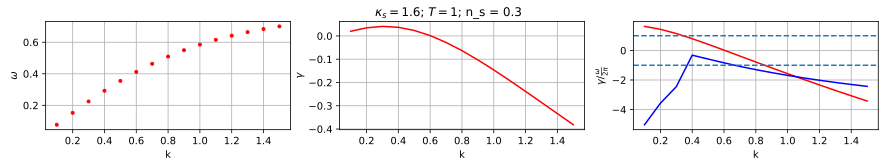

In [231]:
fig = plt.figure(figsize=(15,2))

ax1 = plt.subplot(131)
ax1.plot(k_list,wr_kw_list,'.',color='red')
# ax1.plot(k_list,wr_kw2_list,'.',color='orange')
# ax1.plot(k_list,wr_lw_list,'.',color='blue')
ax1.set_xlabel('k')
ax1.set_ylabel(r'$\omega$')
# ax1.plot(k_list,k_list*v_s,color='black',ls=':')
# ax1.plot(k_list,k_list*v_f,color='green',ls=':')
ax1.grid()

ax2 = plt.subplot(132)
ax2.plot(k_list,wi_kw_list,color='red')
# ax2.plot(k_list,wi_kw2_list,color='orange')
# ax2.plot(k_list,wi_lw_list,color='blue')
ax2.set_xlabel('k')
ax2.set_ylabel(r'$\gamma$')
ax2.grid()

b_kw = np.array(wi_kw_list)/abs(np.array(wr_kw_list)/2/np.pi)
b_kw2 = np.array(wi_kw2_list)/abs(np.array(wr_kw2_list)/2/np.pi)
b_lw = np.array(wi_lw_list)/abs(np.array(wr_lw_list)/2/np.pi)
ax3 = plt.subplot(133)
ax3.plot(k_list,b_kw,color='red')
# ax3.plot(k_list,b_kw2,color='orange')
ax3.plot(k_list,b_lw,color='blue')
ax3.axhline(-1,linestyle='--')
ax3.axhline(1,linestyle='--')
ax3.set_xlabel('k')
ax3.set_ylabel(r'$\gamma/\frac{\omega}{2\pi}$')
ax3.grid()
plt.suptitle(r"$\kappa_s = $"+str(kappa_s)+"; $T = $"+str(T)+"; n_s = "+str(n_s))
plt.show()

### KW波不稳定性：$\gamma >0$
令$a = \frac{u_f}{v_s}$

#### $r_{max}(n_s,a)$图

In [92]:
n_s_list = np.linspace(0.1,0.8,num=16)

In [95]:
n_s=n_s_list[0]
kappa_s = 1.501
T = 1
n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
u_f = a_list[0]*v_s
PrintParas()
s0=op.root(lambda w:PDR_2KE(w,k_list[0]),[0.032,-0.007])
s1=op.root(lambda w:PDR_2KE(w,k_list[0]),[0.046,-0.01])
print('k = ',k_list[0])
print(s0.success,s0.x)
print(s1.success,s1.x)
wr_kw_guess = s0.x[0]
wi_kw_guess = s0.x[1]

+-----+-----+-------+--------+--------+----------+-----+
| T=1 |  n  | kappa |   wp   | theta  | lambda_D |  u  |
+-----+-----+-------+--------+--------+----------+-----+
|  s  | 0.1 | 1.501 | 0.3162 | 0.0365 |  3.1623  |  0  |
|  f  | 0.9 |  inf  | 0.9487 | 1.4142 |  1.0541  | 0.0 |
+-----+-----+-------+--------+--------+----------+-----+
k =  0.1
True [ 0.03268756 -0.00771822]
True [ 0.03268756 -0.00771822]


In [96]:
r_max_mat = []
wr_k0 = 0.0
wi_k0 = 0.0
wr_a0 = 0.0
wi_a0 = 0.0
u_f = 0.0

for n_s_each in tqdm(n_s_list,position=0,leave=True):
    n_s = n_s_each
    r_max_list = []
    for a_each in a_list:
        n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
        u_f = a_each*v_s
        
        r_list=np.array([])
        for k_each in k_list:
            s = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw_guess,wi_kw_guess])
            if s.success==True:
                wr_kw_guess = round(s.x[0],6)
                wi_kw_guess = round(s.x[1],6)
                r_list=np.append(r_list,s.x[1])
            if k_each == k_list[0]:
                wr_k0 = s.x[0]
                wi_k0 = s.x[1]
                if a_each == a_list[0]:
                    wr_a0 = wr_k0
                    wi_a0 = wi_k0
        r_max_list.append(np.amax(r_list))
        wr_kw_guess = wr_k0
        wi_kw_guess = wi_k0
    r_max_mat.append(r_max_list)
    wr_kw_guess = wr_a0
    wi_kw_guess = wi_a0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [2:49:58<00:00, 637.41s/it]


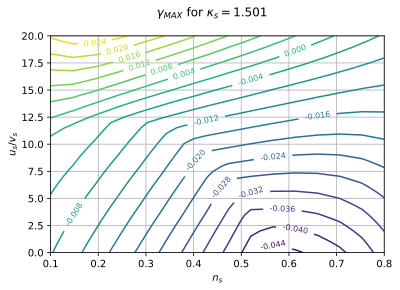

In [101]:
a_grid,n_s_grid=np.meshgrid(a_list,n_s_list)
c = plt.contour(n_s_grid,a_grid,r_max_mat,levels=20)
plt.clabel(c,inline=True,fontsize=8)
plt.suptitle(r'$\gamma_{MAX}$' + r' for $\kappa_s=$'+str(kappa_s))
plt.xlabel('$n_s$')
plt.ylabel('$u_f/v_s$')
plt.grid()
plt.show()

#### $r_{max}(n_s,\kappa_s)$图

In [117]:
kappa_s_list = np.linspace(1.501,1.53,num=15)

In [118]:
n_s=n_s_list[0]
T = 1
kappa_s = kappa_s_list[0]
n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
a = 20
u_f = a*v_s
PrintParas()
s0=op.root(lambda w:PDR_2KE(w,k_list[0]),[0.052,0.0056])
s1=op.root(lambda w:PDR_2KE(w,k_list[0]),[1.127,-1.202])
print('k = ',k_list[0])
print(s0.success,s0.x)
print(s1.success,s1.x)
wr_kw_guess = s0.x[0]
wi_kw_guess = s0.x[1]
wr_lw_guess = s1.x[0]
wi_lw_guess = s1.x[1]

+-----+-----+-------+--------+--------+----------+--------+
| T=1 |  n  | kappa |   wp   | theta  | lambda_D |   u    |
+-----+-----+-------+--------+--------+----------+--------+
|  s  | 0.1 | 1.501 | 0.3162 | 0.0365 |  3.1623  |   0    |
|  f  | 0.9 |  inf  | 0.9487 | 1.4142 |  1.0541  | 0.7301 |
+-----+-----+-------+--------+--------+----------+--------+
k =  0.1
True [0.03515905 0.00673773]
True [ 1.19998324 -1.13599255]


In [119]:
r_max_mat = []
wr_k0 = 0.0
wi_k0 = 0.0
wr_kappa0 = 0.0
wi_kappa0 = 0.0

for n_s_each in tqdm(n_s_list,position=0,leave=True):
    n_s = n_s_each
    n_f = n-n_s
    l_s = np.sqrt( T / n_s / q**2 ) # $\lambda_D^2$
    l_f = np.sqrt( T / n_f / q**2 ) # $\lambda_D^2$
    wp_s = np.sqrt( n_s * q**2 )
    wp_f = np.sqrt( n_f * q**2 )
    r_max_list = []
    for kappa_s_each in kappa_s_list:
        kappa_s = kappa_s_each
        v_s = np.sqrt((2-3/kappa_s)*T/m)
        v_f = np.sqrt(2*T/m)
        u_f = a*v_s
        r_list=np.array([])
        for k_each in k_list:
            s = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw_guess,wi_kw_guess])
            if s.success==True:
                wr_kw_guess = round(s.x[0],6)
                wi_kw_guess = round(s.x[1],6)
                r_list=np.append(r_list,s.x[1])
            if k_each == k_list[0]:
                wr_k0 = s.x[0]
                wi_k0 = s.x[1]
                if kappa_s_each == kappa_s_list[0]:
                    wr_kappa0 = wr_k0
                    wi_kappa0 = wi_k0
        r_max_list.append(np.amax(r_list))
        wr_kw_guess = wr_k0
        wi_kw_guess = wi_k0
    r_max_mat.append(r_max_list)
    wr_kw_guess = wr_kappa0
    wi_kw_guess = wi_kappa0

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [23:52<00:00, 89.56s/it]


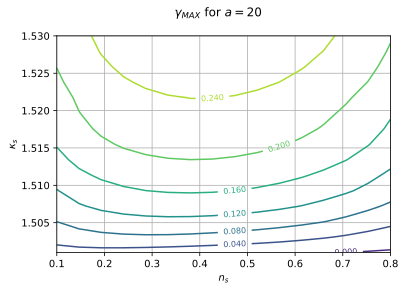

In [120]:
kappa_s_grid,n_s_grid=np.meshgrid(kappa_s_list,n_s_list)
c = plt.contour(n_s_grid,kappa_s_grid,r_max_mat)
plt.clabel(c,inline=True,fontsize=8)
plt.suptitle(r'$\gamma_{MAX}$' + r' for $a=$'+str(a))
plt.xlabel('$n_s$')
plt.ylabel('$\kappa_s$')
plt.grid()
plt.show()

## 模拟验证

### 模拟参数设定

In [168]:
T = 1
n_s = 0.2
kappa_s = 1.501
n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
u_f = 20*v_s
PrintParas()

k = 1.5
L = 2*np.pi/k

vmax = 15 # 速度最大值
nx = 201
nv = 1501
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
dt = 0.02
max_steps  = 10000
data_steps = 2000
data_num = int(max_steps/data_steps)+1
d = 0.001

path = '../data/'
print(data_num)
print('limited time=',2*np.pi/k/dv)
print('real time = ', max_steps*dt)

+-----+-----+-------+--------+--------+----------+--------+
| T=1 |  n  | kappa |   wp   | theta  | lambda_D |   u    |
+-----+-----+-------+--------+--------+----------+--------+
|  s  | 0.2 | 1.501 | 0.4472 | 0.0365 |  2.2361  |   0    |
|  f  | 0.8 |  inf  | 0.8944 | 1.4142 |  1.118   | 0.7301 |
+-----+-----+-------+--------+--------+----------+--------+
6
limited time= 209.43951023931953
real time =  200.0


In [162]:
# 计算特定k的w,r
k_idx = int( (k-k_list[0])/(k_list[1]-k_list[0]) )
s1_k = op.root(lambda w:PDR_2KE(w,k),[wr_kw_list[k_idx],wi_kw_list[k_idx]])
s2_k = op.root(lambda w:PDR_2KE(w,k),[wr_lw_list[k_idx],wi_lw_list[k_idx]])
print(s1_k.success,s1_k.x)
print(s2_k.success,s2_k.x)
w_kw = s1_k.x[0]
r_kw = s1_k.x[1]
w_lw = s2_k.x[0]
r_lw = s2_k.x[1]

True [0.40972929 0.00640697]
True [ 16.6310894  -15.81184904]


### KW条件检验
- $\gamma_{KW} < \gamma_{LW}^{hot}$

In [163]:
print('r_kw = ',round(r_kw,6))
print('r_lw = ',round(r_lw,6))

r_kw =  0.006407
r_lw =  -15.811849


- $k\lambda_h \le 1$

In [164]:
print('k*l_D_f = ',round(k*l_f,6))

k*l_D_f =  1.677051


- $\gamma_{KW} < \omega_r/(2\pi)$

In [165]:
print('r_kw   = ',round(r_kw,6))
print('wr/2/pi = ',round(w_kw/2/np.pi,6))

r_kw   =  0.006407
wr/2/pi =  0.06521


### 模拟结果

In [196]:
dataet = np.loadtxt(os.path.join(path,"tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path,"pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path,"kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)

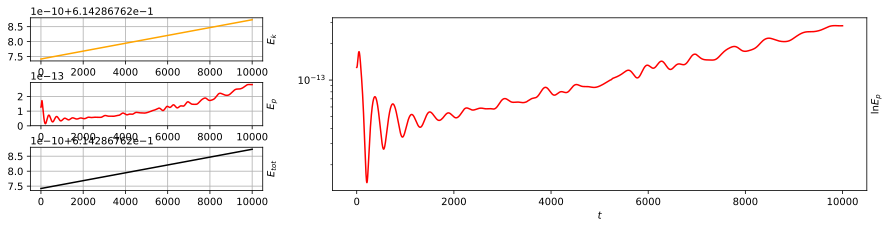

In [197]:
fig = plt.figure(figsize=(15, 3))

ax1 = plt.subplot2grid((3, 3), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.grid()
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")

ax2 = plt.subplot2grid((3, 3), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.grid()
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot2grid((3, 3), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.grid()
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")

axl2 = plt.subplot2grid((3, 3), (0, 1),colspan=2, rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.3)
plt.xlabel(r'$t$')
plt.show()

In [198]:
progesses = np.arange(0,data_num,1)

f = []
phi = []

for progess in progesses:
    f_temp = np.loadtxt(os.path.join(path,"data"+str(progess)))
    f.append(f_temp)
    phi_temp = np.loadtxt(os.path.join(path,"phi"+str(progess)))
    phi.append(phi_temp)

In [199]:
fx0 = np.sum(f[0],axis=1)*dv
fv0 = np.sum(f[0],axis=0)*dx/L
fx = np.sum(f[data_num-1],axis=1)*dv
fv = np.sum(f[data_num-1],axis=0)*dx/L

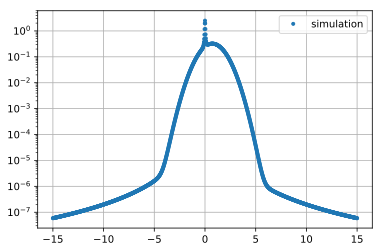

In [200]:
plt.plot(v,fv0,'.',label='simulation')
# plt.plot(v,fk(v),':',label='theory')
plt.grid()
plt.yscale('log')
plt.legend()
plt.show()

$$ E_p \propto E^2 \propto \left( e^{i \omega_r t+\omega_i t} \right)^2 = e^{i 2\omega_r t+2\omega_i t} $$

In [201]:
def PlotWaveFreq(t,y,refFreq,refFreq2):
    n = t.size
    y_k = fftpack.fft(y)
    x_k = fftpack.fftfreq(len(y_k),dt)
    y_k_abs = np.abs(y_k)
    y_k_phi = np.angle(y_k)

    plt.figure(figsize=(10,3))
    
    ax2 = plt.subplot()
    k_plot_scale=n//30
    ax2.plot(np.pi*x_k[1:k_plot_scale],2*y_k_abs[1:k_plot_scale]/n,color='black',lw=2)
    ax2.axvline(refFreq,color='red',ls='--',label=r'$\omega_{KW}$ = '+str(round(refFreq,6)))
    ax2.axvline(refFreq2,color='orange',ls='--',label=r'$\omega_{KW}$ = '+str(round(refFreq2,6)))
    ax2.set_title('freq-wave')
    ax2.set_xlabel(r'$\omega$')
    ax2.set_ylabel('A')
    ax2.grid()
    ax2.legend()
    
    plt.show()
    
def line(p, x):
    k, b = p
    return k*x+b

def errorWithLine(p, x, y):
    r = line(p, x)-y
    return r

def period(x):
    return (x[1]-x[0])/1.

def errPercent(a, b):
    r = abs((a-b)/b)
    return r

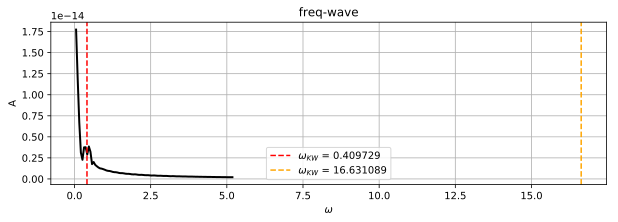

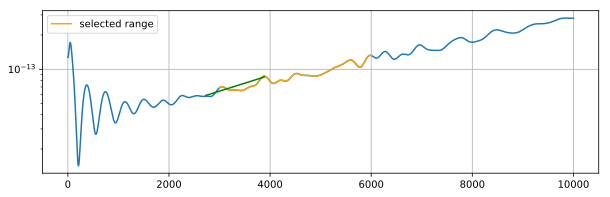

In [202]:
start = 3000
end = 6000

indexes, _ = scipy.signal.find_peaks(dataep, distance=5)
xep = indexes[8:12:1]
yep = np.log(dataep[xep])
para, nouse = op.leastsq(errorWithLine, [-1, 1], args=(xep, yep))
per_sim = period(xep) * dt
wr_sim = 2*np.pi/per_sim/2
wi_sim = para[0]/dt/2

PlotWaveFreq(t[start:end],dataep[start:end],w_kw,w_lw)
fig = plt.figure(figsize=(10,3))
plt.plot(t,dataep)
plt.plot(t[start:end],dataep[start:end],color='orange',label='selected range')
plt.plot(xep,np.exp(line(para,xep)), '-',color='green')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

In [91]:
wr0_err = abs(wr_sim-w_kw)/w_kw*100
wr1_err = abs(wr_sim-w_lw)/w_lw*100
wi0_err = abs((wi_sim-r_kw)/r_kw)*100
wi1_err = abs((wi_sim-r_lw)/r_lw)*100
com_table = PrettyTable(['EAW: k='+str(k),'wr','wi'])
com_table.add_row(['Theory0',round(w_kw,6),round(r_kw,6)])
com_table.add_row(['Theory1',round(w_lw,6),round(r_lw,6)])
com_table.add_row(['Simulation',round(wr_sim,6),round(wi_sim,6)])
com_table.add_row(['Error0(%)',round(wr0_err,6),round(abs(wi0_err),6)])
com_table.add_row(['Error1(%)',round(wr1_err,6),round(abs(wi1_err),6)])
print(com_table)

+------------+-----------+------------+
| EAW: k=1.5 |     wr    |     wi     |
+------------+-----------+------------+
|  Theory0   |  0.409729 |  0.006407  |
|  Theory1   |  3.625301 | -1.902313  |
| Simulation |  0.393683 |  0.005733  |
| Error0(%)  |  3.916244 |  10.51491  |
| Error1(%)  | 89.140673 | 100.301385 |
+------------+-----------+------------+
